# Identifying fraud from Enron Email
Report by Thomas Draebing

## Introduction
Enron was one of the biggest energy companies of the world with revenues of 111 Billion dollars in 2000. In 2001 a willful fraud conspiracy in the company was revealed, which lead to the downfall and bankruptcy of the company. This case of major corruption was one of the biggest of its kind. It is especially interesting for data analysts since the financial data and company internal communication was made public. In this project for the Udacity Data Analyst Nanodegree the aim is to use machine learning techniques to investigate whether the persons of interest in this fraud case can be predicted using the availabe data sets. In future such a model could be used to get an estimate whether a person of interest given its financial and communication data might be a suspect in a fraud case. Thus the whole circle of suspects, which in big companies like Enron can be huge, could be prescreened and the priorities in an investigation could be adjusted accordingly.

## Data Exploration and Preprocessing
#### Initialization of libraries and loading of data set

In [38]:
#Imports

#system file handling
import os
import sys
import pickle

#path to support scripts
sys.path.append("./tools/")

#data structure
import pandas as pd

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

#pretty printing of data
from pprint import pprint

#mathmatical operations
import numpy as np

#machine learning
from feature_format import featureFormat, targetFeatureSplit
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.svm import SVC

In [39]:
#setup plotting in notebook
init_notebook_mode()
%matplotlib inline

In [40]:
#load data
with open("D:/Cloud/Google Drive/Udacity - data Analyst/Data_Analyst_Nanodegree-Project5/data/final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

#### Overview of the data set
The financial data set consists of a nested dictionaries assigning a set of variables to persons who were working in the management of Enron. 

In [41]:
#print POI and total number
print('\nNumber of persons: ' + str(len(data_dict)))
print('Number of POIs: ' + str(sum([data_dict[x]['poi'] for x in data_dict])) + '\n')


Number of persons: 146
Number of POIs: 18



As you can see, there is a total of 146 persons in the data set of which 18 are actual persons of interest, meaning that they were involved in the fraud.

In [42]:
#Create a pandas data frame and removing email variable
df = pd.DataFrame(data_dict).transpose()
pprint(df.columns.tolist())
del df['email_address']
df = df.replace('%','',regex=True).astype('float')

['bonus',
 'deferral_payments',
 'deferred_income',
 'director_fees',
 'email_address',
 'exercised_stock_options',
 'expenses',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'loan_advances',
 'long_term_incentive',
 'other',
 'poi',
 'restricted_stock',
 'restricted_stock_deferred',
 'salary',
 'shared_receipt_with_poi',
 'to_messages',
 'total_payments',
 'total_stock_value']


There are 21 different variables in total. Some contain data of the email correspondance of the person and some about their financial transactions and income. The email-address was removed as a variable since it is person specific and would thus lead to overfitting.

In [43]:
#remove the TOTAL data entry
print('Total accumulated values: ')
pprint(data_dict['TOTAL'])
del data_dict['TOTAL']
df = df.drop('TOTAL')

Total accumulated values: 
{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}


Looking through the entries in the data set the entry TOTAL stands out, since it is clearly not a person, but an accumulative entry. Thus it was removed as an invalid data entry. Nevertheless it shows the summed up financial data, nicely showing what a huge amount of money circulated in the company.

                                   no poi              poi  rel. change
bonus                       986824.923077   2074999.937500     0.524422
deferral_payments           890346.212121    519894.200000    -0.712553
deferred_income            -445998.459459  -1035313.454545     0.569214
director_fees                89822.875000              NaN          NaN
exercised_stock_options    1947752.370787  10463793.666667     0.813858
expenses                     52846.315789     59873.833333     0.117372
from_messages                  668.763889       300.357143    -1.226562
from_poi_to_this_person         58.500000        97.785714     0.401753
from_this_person_to_poi         36.277778        66.714286     0.456222
loan_advances              1200000.000000  81525000.000000     0.985281
long_term_incentive         642709.037736   1204862.416667     0.466571
other                       383128.378378    802997.388889     0.522877
restricted_stock            931007.315217   2318620.764706     0

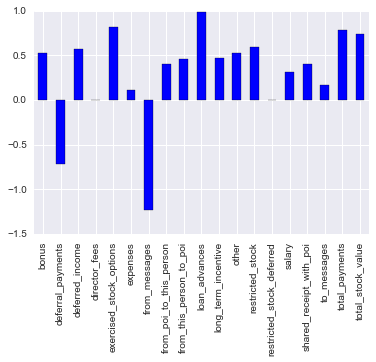

In [44]:
total_mean = df.mean().drop('poi')
poi_mean = df[df['poi'] == 1].mean().drop('poi')
nonpoi_mean = df[df['poi'] == 0].mean().drop('poi')
rel_change = ((poi_mean - nonpoi_mean) / poi_mean) 
print(pd.DataFrame({'poi' : poi_mean,
                    'no poi' : nonpoi_mean,
                    'rel. change' : rel_change
                   }))
rel_change.plot(kind = 'bar')

This plot shows that POIs on average received a lot more money from all the sources. The only variables the non POIs have higher mean values are deferral_payments, director_fees, from_messages and restricted_stock_deffered. Thus pois may identify well with high payment values.

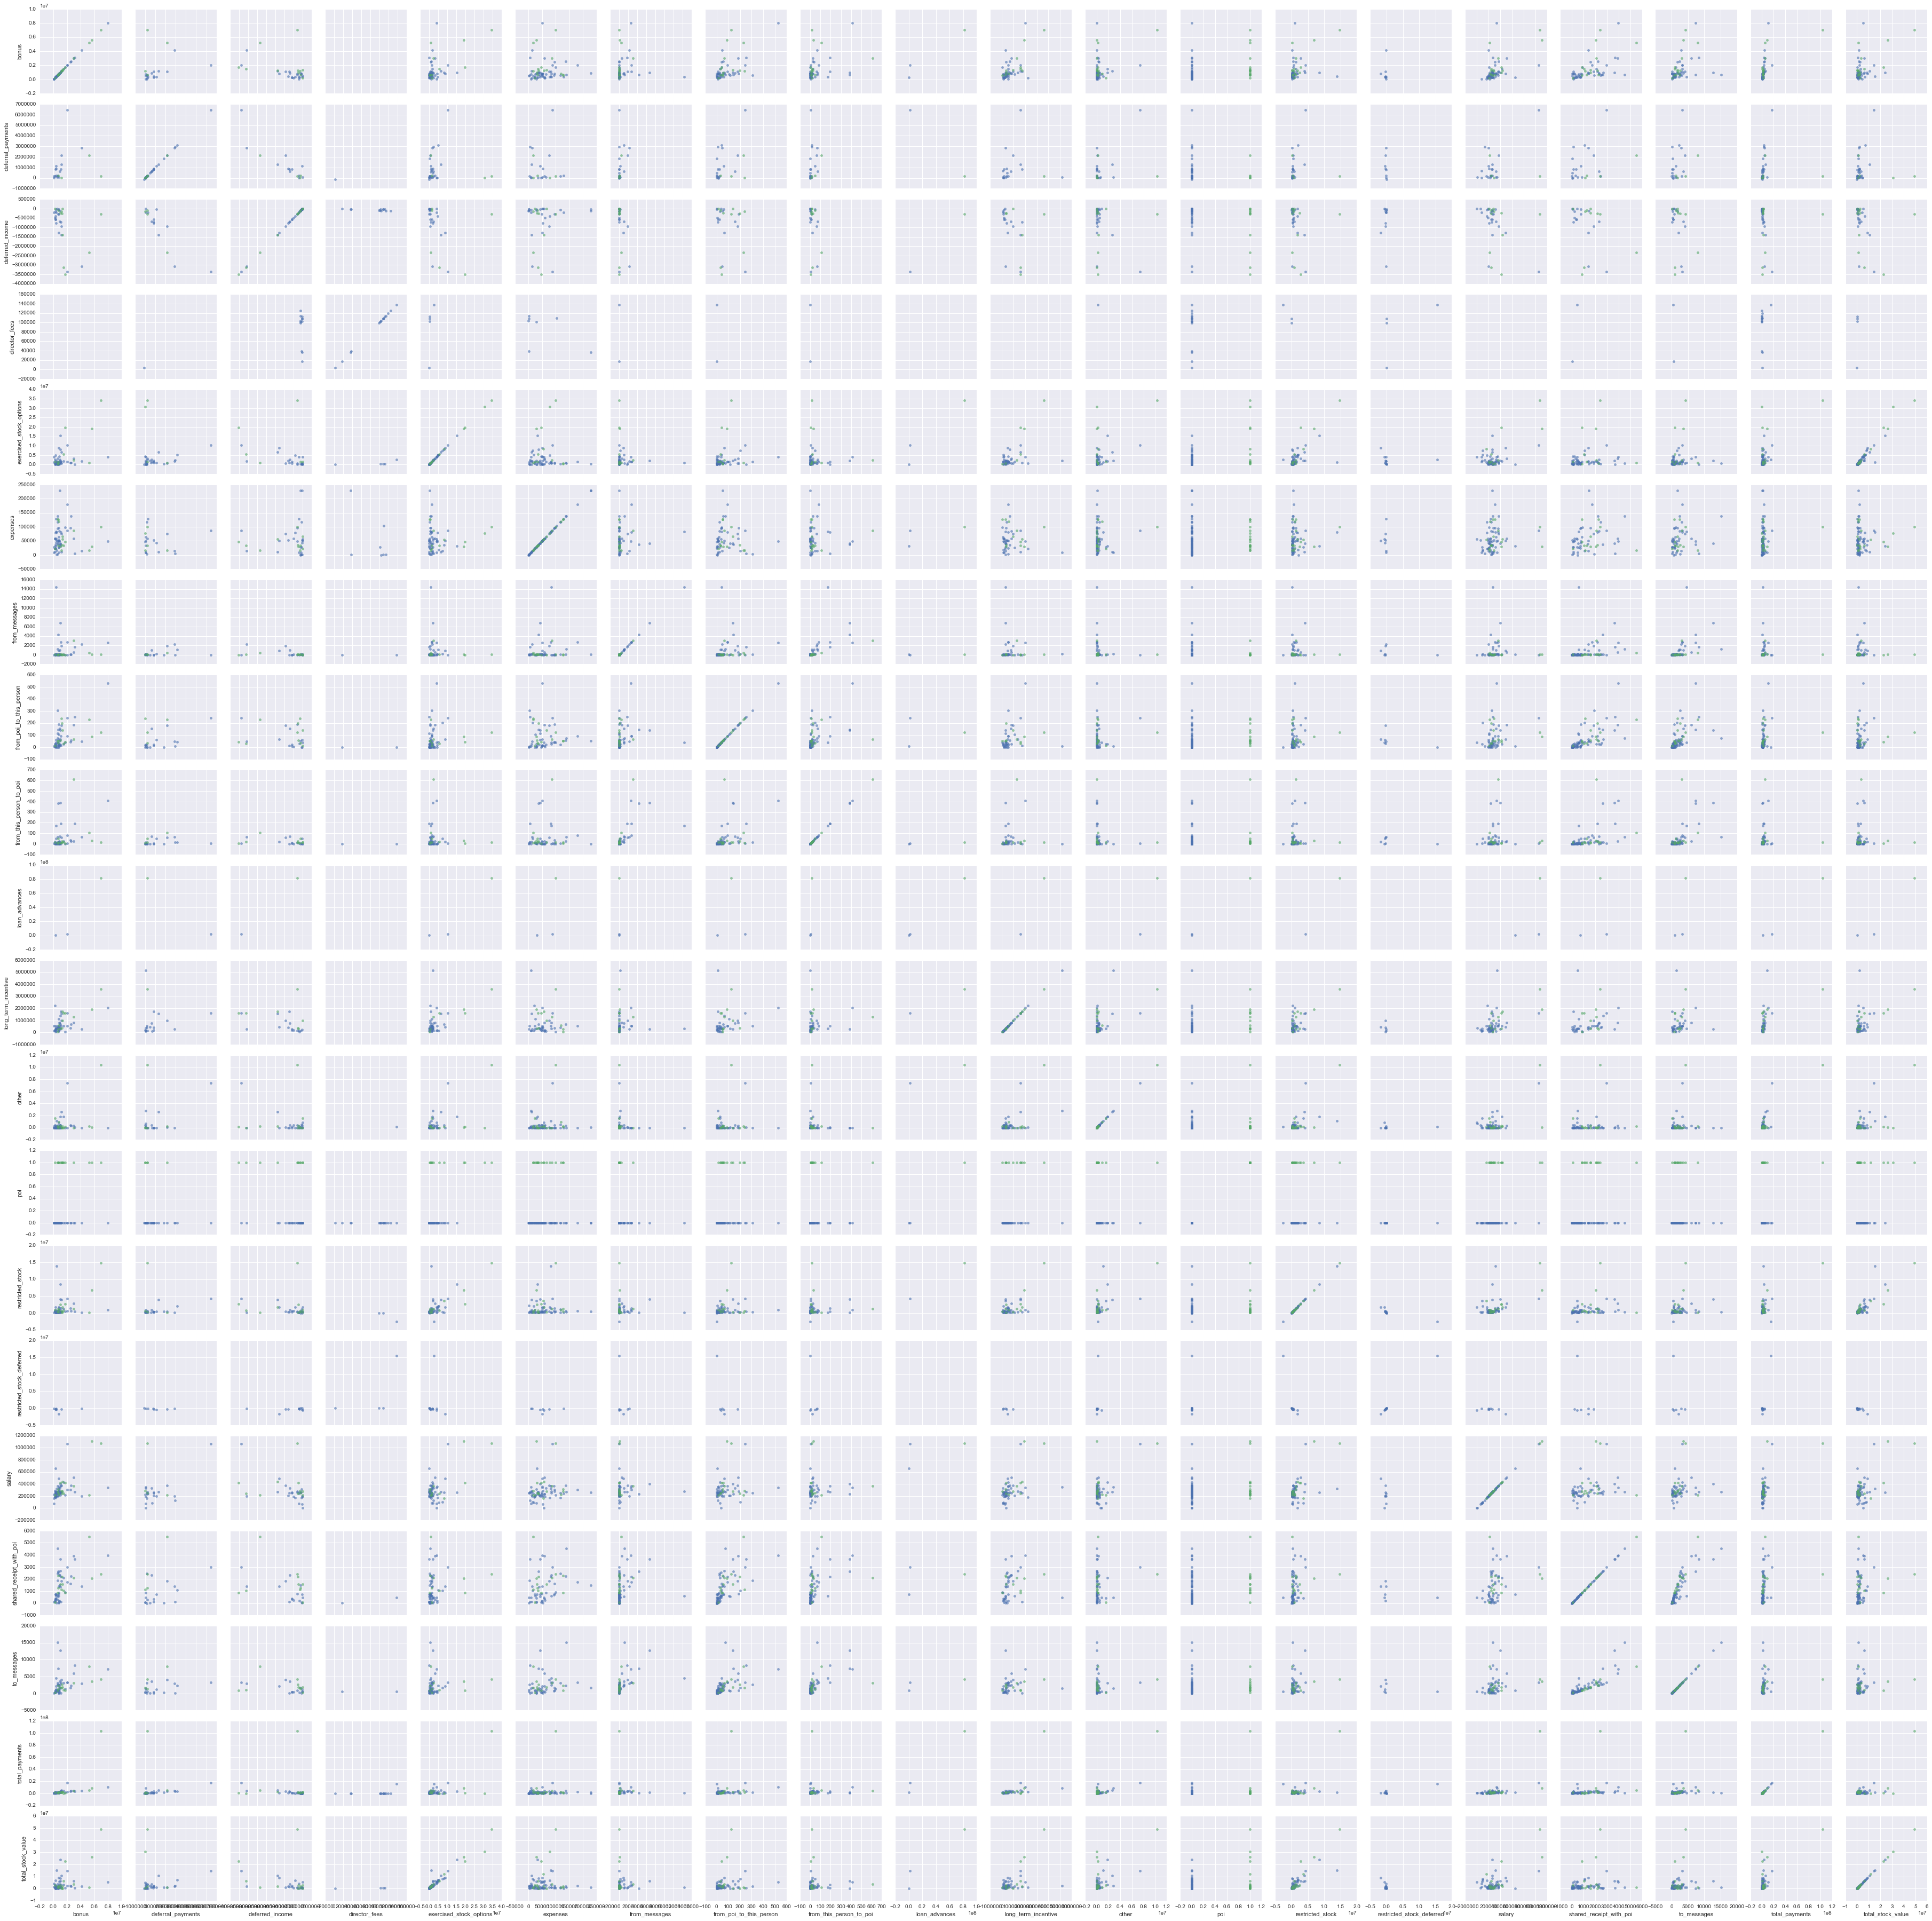

In [45]:
#Creating a scatter matrix
g = sns.PairGrid(df, hue="poi")
g.map(plt.scatter, alpha=0.6)

Without to close inspection the scatter matrix shows that most variables are rather skewed and may include outliers. Additionally the axes show that there are very different value ranges. Some variables also seem to be given by very few entries. All this might interfere with model fitting and should be taken care of first.

In [46]:
#NaN count for variables
print('Fraction of NaNs per variable: ')
print(df.isnull().sum()/len(df.index))

Fraction of NaNs per variable: 
bonus                        0.441379
deferral_payments            0.737931
deferred_income              0.668966
director_fees                0.889655
exercised_stock_options      0.303448
expenses                     0.351724
from_messages                0.406897
from_poi_to_this_person      0.406897
from_this_person_to_poi      0.406897
loan_advances                0.979310
long_term_incentive          0.551724
other                        0.365517
poi                          0.000000
restricted_stock             0.248276
restricted_stock_deferred    0.882759
salary                       0.351724
shared_receipt_with_poi      0.406897
to_messages                  0.406897
total_payments               0.144828
total_stock_value            0.137931
dtype: float64


There are quite a lot NAs in the data set. The variables deffered_income, loan_advances and restricted_stock_deferred are especially rarely given. Since these variable are connected to rare events, this is not surprising. They probably won't add much information to the model.

#### Creating new features
Since, as mentioned above, some variables contain a lot NAs, which is probably due to the fact that they refer to rare events. The numerical information of these variables my add little to the model, but it is possible that those events represented as a binary variable would reduce complexity while still confering most of the information. This is implemented in the following:

In [47]:
#Creating binary variables for variables with high fraction of NaN
df['loan_advances_bin'] = np.zeros((len(df.index), 1)) + 1
df.loc[df['loan_advances'].isnull(), 'loan_advances_bin'] = 0

df['director_fees_bin'] = np.zeros((len(df.index), 1)) + 1
df.loc[df['director_fees'].isnull(), 'director_fees_bin'] = 0

df['restricted_stock_deferred_bin'] = np.zeros((len(df.index), 1)) + 1
df.loc[df['restricted_stock_deferred'].isnull(), 'restricted_stock_deferred_bin'] = 0

df = df.drop(['loan_advances',
              'director_fees',
              'restricted_stock_deferred'], 1)

#### Outlier detection
As a measure to detect outliers the three standard deviations from the mean border was taken. In the following the values of each feature having a greater distance than this threshold are shown:

In [48]:
#extracting values bigger than 3 STDs from the mean
features_train, features_test, labels_train, labels_test = \
    train_test_split(df, df['poi'], test_size=0.3, random_state=42)
del features_train['poi']
del features_test['poi']
for col in features_train.columns:
    t = features_train[np.abs(features_train[col]-features_train[col].mean())>3*features_train[col].std()][col]
    if len(t.index) > 0:
        print(col)
        print(t)
        print('\n')

bonus
BELDEN TIMOTHY N      5249999
LAY KENNETH L         7000000
SKILLING JEFFREY K    5600000
Name: bonus, dtype: float64


deferral_payments
FREVERT MARK A    6426990
Name: deferral_payments, dtype: float64


deferred_income
FREVERT MARK A   -3367011
Name: deferred_income, dtype: float64


exercised_stock_options
HIRKO JOSEPH     30766064
LAY KENNETH L    34348384
Name: exercised_stock_options, dtype: float64


expenses
URQUHART JOHN A     228656
MCCLELLAN GEORGE    228763
Name: expenses, dtype: float64


from_messages
KAMINSKI WINCENTY J    14368
Name: from_messages, dtype: float64


from_poi_to_this_person
DIETRICH JANET R    305
Name: from_poi_to_this_person, dtype: float64


from_this_person_to_poi
BECK SALLY W    386
Name: from_this_person_to_poi, dtype: float64


long_term_incentive
MARTIN AMANDA K    5145434
Name: long_term_incentive, dtype: float64


other
FREVERT MARK A     7427621
LAY KENNETH L     10359729
Name: other, dtype: float64


restricted_stock
LAY KENNETH L      

Nearly every single feature in the data set has at least one outlier. Removing all of them is probably not a good idea, since outliers might yield important information. Remembering the graph depicting the mean differences in the features between pois and non-pois, pois have mostly higher mean values thus with some probability also might be outliers. Looking at the list above this seems to be the case since Kenneth Lay and Jeffrey Skilling, the two most important pois, show up quite often in the outliers. For this model it was decided that outliers in financial features were kept, while outliers in communication features were removed. The reasoning behind this is, that fraud was commited out of financial interest, thus financial outliers might result out of fraud action, while there might be job positions involving a lot of communication, like in public relations, unrelated to fraud activity.
The outliers were removed by setting the values to NaN.

In [49]:
#removing outliers
col_ol = ['from_messages',
          'from_poi_to_this_person',
          'from_this_person_to_poi',
          'shared_receipt_with_poi',
          'to_messages']
def rm_outliers(df, col):
    df_ol = df.copy()
    for col in col_ol:
        index = df[np.abs(df[col] - df[col].mean()) \
              > 3 * df[col].std()][col].index.tolist()
        for i in index:
            df_ol[col][i] = np.NaN
    return df_ol

features_train = rm_outliers(features_train, col_ol)
features_test = rm_outliers(features_test, col_ol)

#### Skewness
As already observed in the scatter matrix the data seems to be skewed. This is also shown by the skewness coefficient:

In [50]:
#Looking for skewness
print(features_train.skew())

bonus                            2.890923
deferral_payments                2.865149
deferred_income                 -2.223301
exercised_stock_options          3.756316
expenses                         1.677811
from_messages                    3.291614
from_poi_to_this_person          1.362598
from_this_person_to_poi          2.880410
long_term_incentive              2.793939
other                            4.749854
restricted_stock                 3.866273
salary                           2.730154
shared_receipt_with_poi          0.984827
to_messages                      1.464830
total_payments                   8.730788
total_stock_value                4.069633
loan_advances_bin                5.624390
director_fees_bin                2.548795
restricted_stock_deferred_bin    2.548795
dtype: float64


To correct for the skewed data non-binary variables are transformed using log10. For salary, shared_receipt_with_poi and expenses the transformation actually did not reduce the skewness, thus they were left untransformed.

In [51]:
#dealing with skewness
#some variables contain zeros, thus 1 is added to them
to_add_one = ['deferred_income',
              'from_poi_to_this_person',
              'from_this_person_to_poi',
              'shared_receipt_with_poi']
features_train[to_add_one] = features_train[to_add_one] + 1
to_transform = ['bonus',
                'deferral_payments',
                'deferred_income',
                'exercised_stock_options',
                'from_messages',
                'from_poi_to_this_person',
                'from_this_person_to_poi',
                'long_term_incentive', 
                'other',
                'restricted_stock',
                'to_messages',
                'total_payments',
                'total_stock_value']
features_train_t = features_train.copy()
features_train_t[to_transform] = features_train[to_transform].apply(np.absolute).apply(np.log10)
print('\nAfter log-transform: ')
print(features_train_t.skew())


After log-transform: 
bonus                            0.398564
deferral_payments               -0.305142
deferred_income                 -0.666840
exercised_stock_options         -0.528349
expenses                         1.677811
from_messages                    1.188213
from_poi_to_this_person         -0.829738
from_this_person_to_poi          0.136753
long_term_incentive             -0.022032
other                            0.102779
restricted_stock                 0.531083
salary                           2.730154
shared_receipt_with_poi          0.984827
to_messages                     -0.660575
total_payments                  -1.603908
total_stock_value                0.200245
loan_advances_bin                5.624390
director_fees_bin                2.548795
restricted_stock_deferred_bin    2.548795
dtype: float64


In [52]:
#Applying transformation to test set
features_test_t = features_test.copy()
features_test_t[to_add_one] = features_test_t[to_add_one] + 1
features_test_t[to_transform] = features_test_t[to_transform].apply(np.absolute).apply(np.log10)

#### Scaling data
The features still have quite different scales:

In [53]:
#Looking at data ranges
print(features_train_t.describe())

           bonus  deferral_payments  deferred_income  exercised_stock_options  \
count  57.000000          26.000000        34.000000                73.000000   
mean    5.882226           5.475914         5.123625                 5.930855   
std     0.375029           0.732404         0.914611                 0.760300   
min     5.000000           3.900968         2.920123                 3.516535   
25%     5.602060           4.981086         4.577042                 5.585154   
50%     5.896939           5.320789         5.150229                 5.929663   
75%     6.079181           6.025359         5.764349                 6.316035   
max     6.845098           6.808008         6.527244                 7.535906   

            expenses  from_messages  from_poi_to_this_person  \
count      66.000000      54.000000                54.000000   
mean    56566.484848       1.823276                 1.431774   
std     48281.132525       0.699263                 0.711904   
min       148.

The different scales might cause problems in the modeling process, since features with very high values might overshadow features with small values, although the trends of both features contain valuable information. Thus the values of each feature are scaled to lie between 0 and 1, 0 being the smallest and 1 being the highest value of the respective feature.

In [54]:
#MinMax Scaling
def minmax(df):
    df_scaled = df.copy()
    for col in df.columns:
        col_min = np.nanmin(df[col], axis = None)[0]
        col_max = np.nanmax(df[col], axis = None)[0]
        if (col_max - col_min) == 0:
            X_scaled = df[col]
        else:
            X_std = [((X - col_min) / (col_max - col_min)) for X in df[col]]
            
            std_min = np.nanmin(X_std, axis = None)
            std_max = np.nanmax(X_std, axis = None)
            X_scaled = [(X * (std_max - std_min) + std_min) for X in X_std] 
        
        df_scaled[col] = X_scaled
    return df_scaled

features_train_t = minmax(features_train_t)
features_test_t = minmax(features_test_t)

print(features_train_t.describe())

           bonus  deferral_payments  deferred_income  exercised_stock_options  \
count  57.000000          26.000000        34.000000                73.000000   
mean    0.478146           0.541770         0.610875                 0.600671   
std     0.203257           0.251941         0.253557                 0.189159   
min     0.000000           0.000000         0.000000                 0.000000   
25%     0.326302           0.371553         0.459347                 0.514662   
50%     0.486120           0.488408         0.618251                 0.600374   
75%     0.584891           0.730775         0.788503                 0.696502   
max     1.000000           1.000000         1.000000                 1.000000   

        expenses  from_messages  from_poi_to_this_person  \
count  66.000000      54.000000                54.000000   
mean    0.246784       0.290820                 0.596225   
std     0.211190       0.273298                 0.296454   
min     0.000000       0.00000

#### Preprocessing - Results
The following plot shows an updated scatter matrix:

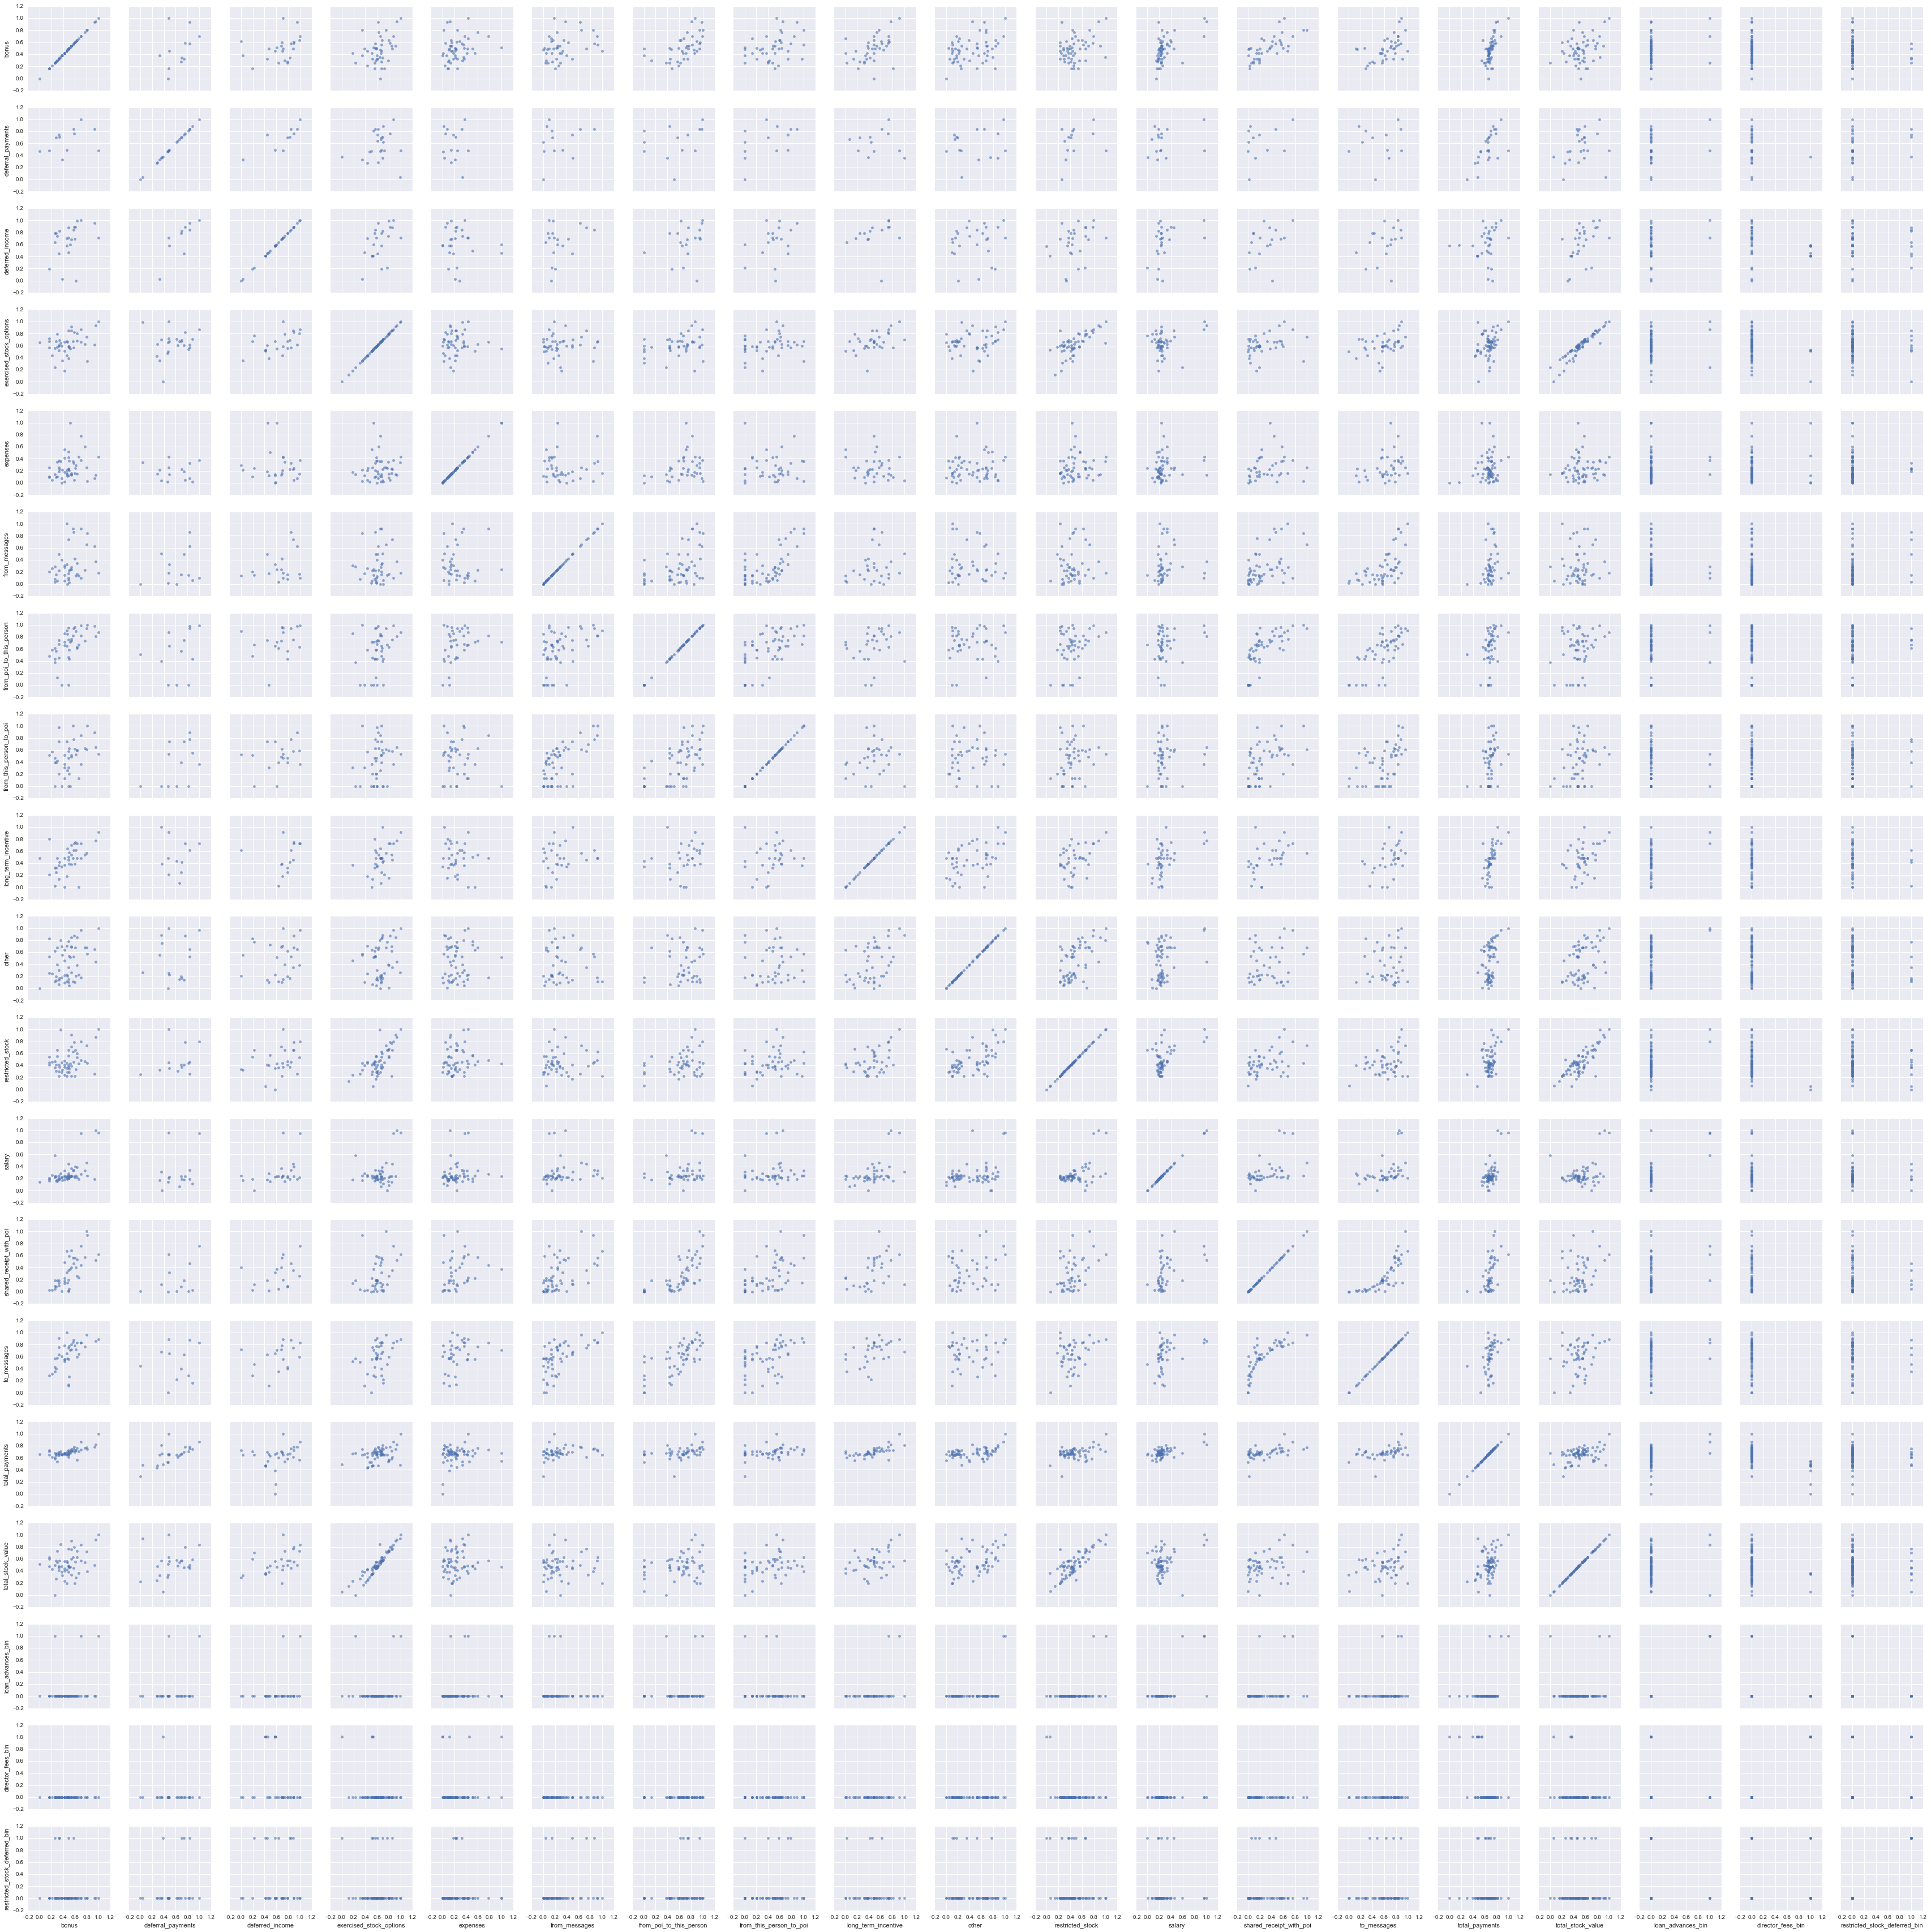

In [55]:
#Draw new scatter matrix
g = sns.PairGrid(features_train_t)
g.map(plt.scatter, alpha = 0.6)

The data points are now much better distributed and should be much better suited for modelling.

#### Feature Selection

In [56]:
#creating a temporary array for feature investigation
train = pd.concat([features_train_t, labels_train], axis=1)
data_dict = train.transpose().to_dict()

features_list = ['poi',
                 'bonus',
                 'deferral_payments',
                 'deferred_income',
                 'director_fees_bin',
                 'exercised_stock_options',
                 'expenses',
                 'from_messages',
                 'from_poi_to_this_person',
                 'from_this_person_to_poi',
                 'loan_advances_bin',
                 'long_term_incentive',
                 'other',
                 'restricted_stock',
                 'restricted_stock_deferred_bin',
                 'salary',
                 'shared_receipt_with_poi',
                 'to_messages',
                 'total_payments',
                 'total_stock_value']
data = featureFormat(data_dict, features_list, sort_keys = True)
data = np.nan_to_num(data)
labels, features = targetFeatureSplit(data)

As a first test method to detect less important features a correlation coefficient matrix was created:

In [57]:
#Creating a correlation matrix
cor_mat = np.corrcoef(np.array(features).T)
data = [go.Heatmap(z = cor_mat,
                   x = features_list[1:],
                   y = features_list[1:],
                   zauto = False,
                   zmax = 1,
                   zmin = -1)]
iplot(data)

Values close to 1 or -1 hint to a high correlation, which might hint that only one of the correlating variables would be needed for a good model. The following variables are highly correlated:

- total_stock_value : exercised_stock_options (0.83)
- to_messages : from_poi_to_this_person (0.80)
- salary : bonus (0.78)
- shared_receipt_with_poi : from_poi_to_person (0.76)
- to_messages : shared_receipt_with_poi (0.75)
- from_this_person_to_poi : from_poi_to_this_person (0.74)
- total_stock_value : restricted_stock (0.71)

One observation here is quite interesting: The variable total_stock_value seems to have quite high correlation coefficients with other variables concerning stocks. This is not surprising since the 'total' variables are probably summed up values of other variables, they are linear dependent to those variables, thus correlated and probably not very useful for modeling. The same should be true for total_payments, although not visible in this plot, probably because it consists of to many summed up features that act independently.

Next a lasso model was created for further investigation:

In [58]:
#Creating a lasso model
clf = linear_model.Lasso(max_iter=1000000)
clf.fit(features, labels)
f = features_list[1:]
t = np.where(clf.coef_ == 0)[0].tolist()
print(clf.coef_)
print([f[x] for x in t])

[ 0. -0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.
  0.]
['bonus', 'deferral_payments', 'deferred_income', 'director_fees_bin', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances_bin', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred_bin', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']


The lasso model sets the cofactors of all variables to zero. Thus is not able to model the data and not helpful for feature selection.
Further a decision tree classifier was build and the feature importances calculated to get a better idea of which features are not needed for a good model:

In [59]:
#creating a decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(features, labels)
t = np.where(clf.feature_importances_ == 0)[0].tolist()
print([f[x] for x in t])
print([clf.feature_importances_[x] for x in t])

['deferral_payments', 'deferred_income', 'director_fees_bin', 'from_messages', 'loan_advances_bin', 'long_term_incentive', 'restricted_stock', 'restricted_stock_deferred_bin', 'to_messages', 'total_payments']
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


There are quite some features which are given an importance of zero by the decision tree classifier. Not surprisingly director_fees_bin, loan_advances_bin and restricted_stock_deferred_bin are again under them. Also total_stock_value is under the less important variables. The number of messages sent and received also seems to be of little importance for a decision tree model. Surprisingly salary also shows up in the list.

As a forth method a k-best selector was used:

In [60]:
#Using k-Best model to select features with lowest score
clf = SelectKBest()
clf.fit(features, labels)
t = np.where(clf.scores_ < np.percentile(clf.scores_, 25))[0].tolist()
print([f[x] for x in t])
print([clf.scores_[x] for x in t])

['deferral_payments', 'exercised_stock_options', 'from_messages', 'loan_advances_bin']
[0.011933087002216623, 0.78094588618354133, 0.40982851623306771, 0.97182264509561178]


Here the features in the lower quartile of scores was chosen as candidates for removal.
All this methods give us a lot of features to consider for removing them from the data set for modeling. The feature list was finally set up considering this results and optimizing it considering the evaluation scores after building the model. Thus variables which did not improve the scores considerably were removed. Interestingly, restricted_stock_deferred_bin was not under them and was kept in the model.
The final feature list looked as follows:

In [61]:
#defining reduced feature list, applying it to dataframe and creating training-, test set
features_list = ['poi', 
                'bonus',
                'deferred_income',
                'exercised_stock_options',
                'expenses',
                'long_term_incentive',
                'other',
                'restricted_stock',
                'salary',
                'restricted_stock_deferred_bin',
                'shared_receipt_with_poi',
                'to_messages']
features_train_reduced = features_train.copy()[features_list[1:]]
features_test_reduced = features_test.copy()[features_list[1:]]

## Model setup
Before the data can actually be fed to classifiers NaNs will have to be removed. Two imputing methods were tested: Imputing with zeros and imputing with the respective features means:

In [62]:
features_train_scaled_imp = features_train_t.fillna(0)
features_test_scaled_imp = features_test_t.fillna(0)

As a first quick test four different vanilla classifiers will be trained and the accuracy used as an evaluation score. Namely these are Gaussian Naive Bayes, Random Forest, Ada Boost and Support Vector Classifiers. This is done for both imputing methods.

In [63]:
#Classifier
clf_gnb = GaussianNB()
clf_gnb.fit(features_train_scaled_imp, labels_train)

clf_rf = RandomForestClassifier()
clf_rf.fit(features_train_scaled_imp, labels_train)

clf_ab = AdaBoostClassifier()
clf_ab.fit(features_train_scaled_imp, labels_train)

clf_svm = SVC()
clf_svm.fit(features_train_scaled_imp, labels_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [64]:
print('GaussianNB: ')
print(clf_gnb.score(features_test_scaled_imp, labels_test))
print(clf_gnb.predict(features_test_scaled_imp))

print('\nRandom Forest: ')
print(clf_rf.score(features_test_scaled_imp, labels_test))
print(clf_rf.predict(features_test_scaled_imp))

print('\nAda Boost: ')
print(clf_ab.score(features_test_scaled_imp, labels_test))
print(clf_ab.predict(features_test_scaled_imp))

print('\nSVM: ')
print(clf_svm.score(features_test_scaled_imp, labels_test))
print(clf_svm.predict(features_test_scaled_imp))

GaussianNB: 
0.454545454545
[ 1.  0.  0.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  0.  1.  0.  1.  0.  1.  1.  0.  0.  1.  0.  1.  0.  1.  0.  1.  1.  1.
  1.  0.  0.  1.  1.  1.  0.  0.]

Random Forest: 
0.909090909091
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]

Ada Boost: 
0.909090909091
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  1.]

SVM: 
0.909090909091
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]


The accuracy seems to be the wrong evaluation metric for the given data, since although the SVM classifier predicts only non POIs it receives a high accuracy. This is due to the small fraction of POIs in the data set. Thus a script based on the given tester.py script was created to allow pipelining preprocessing and testing of several classifiers and receiving more evaluation metrics:

In [65]:
clf_list = {}
clf_list['GaussianNB'] = GaussianNB()
clf_list['RandomForestVanilla'] = RandomForestClassifier()
clf_list['AdaBoostVanilla'] = AdaBoostClassifier()
clf_list['svm'] = SVC()

#The actual algorithm will be run separately from the ipython notebook, since the kernel seems to freeze. 
#It works fine when running it from spyder.

#with open("final_project_dataset.pkl", "r") as data_file:
#        data_dict = pickle.load(data_file)
#
#import classifier_tester as ct
#df_preproc = ct.preprocess_enron(data_dict)
#cv = StratifiedShuffleSplit(df_preproc['poi'], 1000, random_state = 42)
#ct.evaluate_clf(df_preproc, clf_list, cv)

The code was not run inside the notebook, since the runtime is quite long and often led to the notebook crashing. The evaluation scores were as follows:
- GaussianNB (vanilla)
    - Accuracy: 0.54200
    - Precision: 0.21850
    - Recall: <b>0.94500</b>
    - F1: <b>0.35493</b>
    - F2: <b>0.56757</b>
    - True positives: <b>1890</b>
    - False positives: 6760 
    - False negatives:  <b>110</b>
    - True negatives: 6240
- SVM (vanilla)
    - Precision or recall may be undefined due to a lack of true positive predicitons.
- RandomForest (vanilla)
    - Accuracy: <b>0.85587</b>
    - Precision: <b>0.35689</b> 
    - Recall: 0.10100
    - F1: 0.15744
    - F2: 0.11791
    - True positives:  202
    - False positives:  <b>364</b>
    - False negatives: 1798
    - True negatives: <b>12636</b>
- AdaBoost (vanilla)
    - Accuracy: 0.82413
    - Precision: 0.32415
    - Recall: 0.29400
    - F1: 0.30834
    - F2: 0.29957
    - True positives:  588
    - False positives: 1226
    - False negatives: 1412
    - True negatives: 11774

      accuracy        f1        f2  precision  recall
0.25  0.827800  0.308804  0.296292   0.332182  0.2885
0.50  0.825200  0.316119  0.308115   0.330425  0.3030
0.75  0.829800  0.326207  0.315660   0.345444  0.3090
1.00  0.833333  0.329759  0.316033   0.355491  0.3075
1.25  0.833000  0.313887  0.296860   0.347062  0.2865
1.50  0.831867  0.310552  0.294057   0.342581  0.2840


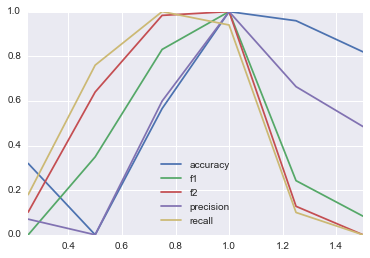

In [66]:
learning_rate = {0.25: {'accuracy': 0.8278,
                        'f1': 0.3088038533583088,
                        'f2': 0.2962924925541748,
                        'precision': 0.33218192285549797,
                        'recall': 0.2885},
                0.50: {'accuracy': 0.8252,
                       'f1': 0.3161189358372457,
                       'f2': 0.3081147040878584,
                       'precision': 0.33042529989094876,
                       'recall': 0.303},
                0.75: {'accuracy': 0.8298,
                       'f1': 0.3262074425969913,
                       'f2': 0.3156604351823475,
                       'precision': 0.3454443823365008,
                       'recall': 0.309},
                1.00: {'accuracy': 0.8333333333333334,
                       'f1': 0.3297587131367292,
                       'f2': 0.316032887975334,
                       'precision': 0.3554913294797688,
                       'recall': 0.3075},
                1.25: {'accuracy': 0.833,
                       'f1': 0.31388660640920296,
                       'f2': 0.29686042897109105,
                       'precision': 0.3470623864324652,
                       'recall': 0.2865},
                1.50: {'accuracy': 0.8318666666666666,
                       'f1': 0.31055221432476765,
                       'f2': 0.2940567405259888,
                       'precision': 0.3425814234016888,
                       'recall': 0.284}}
learning_rate = pd.DataFrame(learning_rate).transpose()
print(learning_rate)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(learning_rate)
learning_rate_scaled = pd.DataFrame(scaled)
learning_rate_scaled.columns = learning_rate.columns
learning_rate_scaled.index = learning_rate.index
learning_rate_scaled.plot()

F1- and F2-score are maximized at a learning rate of 1.0.

     accuracy        f1        f2  precision  recall
10   0.820267  0.277986  0.266591   0.299308  0.2595
50   0.824133  0.308338  0.299572   0.324146  0.2940
100  0.829800  0.326207  0.315660   0.345444  0.3090
125  0.834533  0.327007  0.311210   0.357227  0.3015
150  0.835667  0.316227  0.296720   0.355140  0.2850
175  0.836000  0.318182  0.298709   0.356965  0.2870
250  0.836333  0.314820  0.294271   0.356286  0.2820


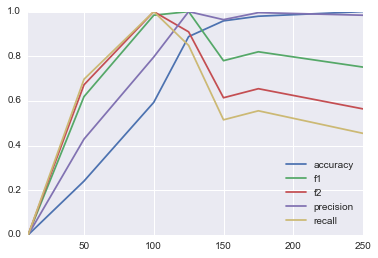

In [67]:
n_est = { 100 : {'accuracy': 0.8298,
                 'f1': 0.3262074425969913,
                 'f2': 0.3156604351823475,
                 'precision': 0.3454443823365008,
                 'recall': 0.309},
         10 : {'f1': 0.2779860739153723, 
               'recall': 0.2595, 
               'f2': 0.26659132936100266, 
               'precision': 0.29930795847750863, 
               'accuracy': 0.8202666666666667},
         250 : {'f1': 0.3148199832542562, 
                'recall': 0.282, 
                'f2': 0.2942711050819159, 
                'precision': 0.3562855337965888, 
                'accuracy': 0.8363333333333334},
         50 : {'f1': 0.3083377031987415, 
               'recall': 0.294, 
               'f2': 0.29957203994293863, 
               'precision': 0.3241455347298787, 
               'accuracy': 0.8241333333333334},
        150 : {'f1': 0.31622746185852985, 
               'recall': 0.285, 
               'f2': 0.29672045809474235, 
               'precision': 0.35514018691588783, 
               'accuracy': 0.8356666666666667}, 
        175 : {'f1': 0.3181818181818182, 
               'recall': 0.287, 
               'f2': 0.29870940882597835, 
               'precision': 0.35696517412935325, 
               'accuracy': 0.836}, 
        125 : {'f1': 0.3270065075921909, 
               'recall': 0.3015, 
               'f2': 0.3112097440132122, 
               'precision': 0.3572274881516588, 
               'accuracy': 0.8345333333333333}}
n_est = pd.DataFrame(n_est).transpose()
print(n_est)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(n_est)
n_est_scaled = pd.DataFrame(scaled)
n_est_scaled.columns = n_est.columns
n_est_scaled.index = n_est.index
n_est_scaled.plot()

F1- and F2-score are maximized at a n_estimator value of 100.

    accuracy        f1        f2  precision  recall
0   0.829800  0.326207  0.315660   0.345444  0.3090
2   0.850800  0.235133  0.192695   0.371490  0.1720
4   0.852533  0.166541  0.127687   0.337920  0.1105
8   0.791800  0.223328  0.224030   0.222167  0.2245
16  0.786533  0.225448  0.229919   0.218369  0.2330
24  0.786867  0.227218  0.231824   0.219934  0.2350
32  0.785000  0.234875  0.242291   0.223476  0.2475
64  0.786533  0.234338  0.240621   0.224565  0.2450


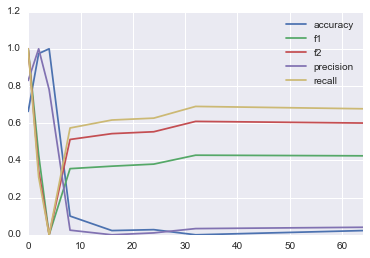

In [68]:
max_depth = {4 : {'f1': 0.16654107008289373, 
                  'recall': 0.1105, 
                  'f2': 0.1276866189045528, 
                  'precision': 0.3379204892966361, 
                  'accuracy': 0.8525333333333334}, 
             2 : {'f1': 0.23513328776486672, 
                  'recall': 0.172, 
                  'f2': 0.19269549630293523, 
                  'precision': 0.3714902807775378, 
                  'accuracy': 0.8508}, 
             0 : {'accuracy': 0.8298,
                 'f1': 0.3262074425969913,
                 'f2': 0.3156604351823475,
                 'precision': 0.3454443823365008,
                 'recall': 0.309},
             8 : {'f1': 0.22332753046505843, 
                  'recall': 0.2245, 
                  'f2': 0.22402953797026245, 
                  'precision': 0.22216724393864423, 
                  'accuracy': 0.7918},
             16: {'f1': 0.2254475084663764, 
                  'recall': 0.233, 
                  'f2': 0.22991908427077165, 
                  'precision': 0.21836925960637302, 
                  'accuracy': 0.7865333333333333},
             24: {'f1': 0.22721779066956732, 
                  'recall': 0.235, 
                  'f2': 0.23182401104863373, 
                  'precision': 0.21993448759943846, 
                  'accuracy': 0.7868666666666667},
             32: {'f1': 0.23487544483985764, 
                  'recall': 0.2475, 
                  'f2': 0.24229074889867838, 
                  'precision': 0.2234762979683973, 
                  'accuracy': 0.785}, 
             64: {'f1': 0.234337637494022, 
                  'recall': 0.245, 
                  'f2': 0.24062070320172851, 
                  'precision': 0.22456461961503207, 
                  'accuracy': 0.7865333333333333}}
max_depth = pd.DataFrame(max_depth).transpose()
print(max_depth)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(max_depth)
max_depth_scaled = pd.DataFrame(scaled)
max_depth_scaled.columns = max_depth.columns
max_depth_scaled.index = max_depth.index
max_depth_scaled.plot()

<b>Note: </b> The max_depth value 0 is a dummy for the value None, to allow for plotting!
Keeping the max_depth unlimited gives the best result.

    accuracy        f1        f2  precision  recall
1   0.829800  0.326207  0.315660   0.345444  0.3090
2   0.854600  0.178531  0.136915   0.361832  0.1185
4   0.857333  0.221252  0.173754   0.406417  0.1520
6   0.851067  0.224306  0.181869   0.367045  0.1615
8   0.847667  0.235530  0.195795   0.355915  0.1760
10  0.839867  0.227156  0.193786   0.318592  0.1765
25  0.819133  0.236850  0.220304   0.270740  0.2105


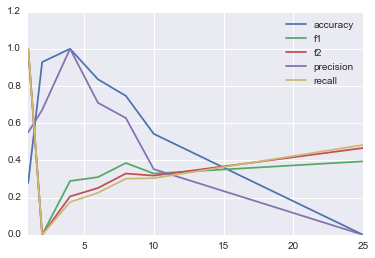

In [69]:
mls = {1 : {'accuracy': 0.8298,
                 'f1': 0.3262074425969913,
                 'f2': 0.3156604351823475,
                 'precision': 0.3454443823365008,
                 'recall': 0.309},
       8: {'f1': 0.23553027768484444, 
                        'recall': 0.176, 
                        'f2': 0.1957948603849149, 
                        'precision': 0.35591506572295245, 
                        'accuracy': 0.8476666666666667}, 
       4: {'f1': 0.22125181950509462, 
                        'recall': 0.152, 
                        'f2': 0.17375400091449475, 
                        'precision': 0.40641711229946526, 
                        'accuracy': 0.8573333333333333}, 
       6: {'f1': 0.22430555555555556, 
                        'recall': 0.1615, 
                        'f2': 0.1818693693693694, 
                        'precision': 0.36704545454545456, 
                        'accuracy': 0.8510666666666666}, 
       2: {'f1': 0.17853107344632768, 
                        'recall': 0.1185, 
                        'f2': 0.13691507798960137, 
                        'precision': 0.3618320610687023, 
                        'accuracy': 0.8546}, 
       25: {'f1': 0.2368495077355837, 
                         'recall': 0.2105, 
                         'f2': 0.22030350601779172, 
                         'precision': 0.2707395498392283, 
                         'accuracy': 0.8191333333333334}, 
       10: {'f1': 0.22715572715572716, 
                         'recall': 0.1765, 
                         'f2': 0.19378568291611772, 
                         'precision': 0.3185920577617328, 
                         'accuracy': 0.8398666666666667}}
mls = pd.DataFrame(mls).transpose()
print(mls)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(mls)
mls_scaled = pd.DataFrame(scaled)
mls_scaled.columns = mls.columns
mls_scaled.index = mls.index
mls_scaled.plot()

The minimum samples per leaf should be kept at 2.

In [70]:
clf_list = {}

clf_list['AdaBoost'] = AdaBoostClassifier(n_estimators=100,
                                          learning_rate=1,
                                          algorithm="SAMME")
clf_list['AdaBoostR'] = AdaBoostClassifier(n_estimators=100,
                                           learning_rate=1)

#ct.evaluate_clf(df_preproc, clf_list, cv)

AdaBoostR
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=100, random_state=None)
        Accuracy: 0.83327       Precision: 0.35495          Recall: 0.30650     F1: 0.32895     F2: 0.31510
        Total predictions: 15000        True positives:  613    False positives: 1114           False negatives: 1387   True negatives: 11886

- AdaBoost (tuned/discrete)
    - Accuracy: 0.82840
    - Precision: 0.32152
    - Recall: 0.25850
    - F1: 0.28659
    - F2: 0.26905
- AdaBoost (tuned/continuous)
    - Accuracy: <b>0.8298</b>
    - Precision: <b>0.3454</b>
    - Recall: <b>0.309</b>
    - F1: <b>0.3262</b>
    - F2: <b>0.3156</b>
